In [ ]:
##importing all the dependencies required for this project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter, freqz
from pyspark.sql import SparkSession, functions, types
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.functions as F
import pyspark.sql.functions as func
from pyspark.sql import Window

In [ ]:
##Configuring spark
spark = SparkSession.builder.appName('Elevator Anamoly').getOrCreate()
spark.sparkContext.setLogLevel('WARN')
assert spark.version >= '2.4'  # make sure we have Spark 2.4+

In [3]:
##Reading the input data
input = '/home/keerthi/EDS_10.csv'
# Defining the schema for sensor datasets
def sensor_schema():
    sen_schema = types.StructType([
        types.StructField('timestamp', types.StringType()),
        types.StructField('X', types.DoubleType()),
        types.StructField('Y', types.DoubleType()),
        types.StructField('Z', types.DoubleType()),
    ])
    return sen_schema

sens_schema = sensor_schema()

#Spark read of data
temp = spark.read.csv(input, schema=sens_schema)

In [6]:
##Creating a SQL table
##Considering -ve Z axis for analysis

temp.createOrReplaceTempView("temp")
temp = spark.sql("select timestamp,Z*-1 from temp where timestamp between '2018-07-09 12:00:00' and '2018-08-09 12:00:00'")

In [10]:
##Renaming the column
temp = temp.withColumnRenamed('(Z * CAST(-1 AS DOUBLE))', 'Z')

In [11]:
# UDF for converting column type from vector to double type
unlist = F.udf(lambda x: round(float(list(x)[0]),6), types.DoubleType())

assembler = VectorAssembler(
    inputCols=["Z"],
    outputCol="Zvector")
tempdata = assembler.transform(temp)
scaler = StandardScaler(inputCol="Zvector", outputCol="Zscale",withMean=True, withStd=True)
scalerModel = scaler.fit(tempdata)
scaledData = scalerModel.transform(tempdata).withColumn("Zscale", unlist("Zscale")).drop("Zvector").cache()
scaledData.show()

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.066406|-0.413567|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.070313|-0.197054|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.070313|-0.197054|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.078125| 0.235862|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.078125| 0.235862|
|2018-07-09 12:00:...|1.078125| 0.235862|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.070313|-0.197054|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.074219| 0.019404|
|2018-07-09 12:00:...|1.070313|-0.197054|
|2018-07-09 12:00:...|1.070313|-0.197054|
|2018-07-09 12:00:...|1.078125| 0.235862|
+--------------------+--------+---

In [12]:
scaledData.sort(F.desc("Zscale")).show(5000)

+--------------------+--------+---------+
|           timestamp|       Z|   Zscale|
+--------------------+--------+---------+
|2018-07-17 11:29:...|1.269531|10.842955|
|2018-07-27 14:28:...|1.261719|10.410039|
|2018-07-27 14:29:...|1.253906| 9.977069|
|2018-07-27 14:27:...|1.253906| 9.977069|
|2018-07-27 14:27:...|1.253906| 9.977069|
|2018-07-27 14:28:...|    1.25| 9.760611|
|2018-07-27 14:29:...|1.246094| 9.544153|
|2018-07-27 14:27:...|1.246094| 9.544153|
|2018-07-27 14:26:...|1.242188| 9.327695|
|2018-07-27 14:27:...|1.242188| 9.327695|
|2018-07-27 14:21:...|1.242188| 9.327695|
|2018-07-27 14:26:...|1.238281| 9.111182|
|2018-07-27 14:27:...|1.238281| 9.111182|
|2018-07-27 14:27:...|1.238281| 9.111182|
|2018-07-27 14:27:...|1.238281| 9.111182|
|2018-07-27 14:20:...|1.238281| 9.111182|
|2018-07-27 14:29:...|1.238281| 9.111182|
|2018-07-27 14:26:...|1.234375| 8.894725|
|2018-07-27 14:19:...|1.234375| 8.894725|
|2018-07-27 14:26:...|1.234375| 8.894725|
|2018-07-27 14:27:...|1.234375| 8.

In [84]:
dummy_df = scaledData.withColumn('Zround', F.round(scaledData['Zscale']))
new_df = dummy_df.groupby('Zround').agg(F.count('Zround').alias('Zcount'))

In [121]:
new_df = new_df.sort(F.desc('Zcount'))
pandas_df = new_df.toPandas()
pandas_df.to_csv('/home/keerthi/count10.csv')
#new_df.show()


In [ ]:
scaledData.sort("Zscale").show()

In [113]:
scaledData.createOrReplaceTempView("scaledData")
temp_df = spark.sql("select timestamp,Zscale from scaledData where timestamp between '2018-07-26 15:10:00' and '2018-07-26 15:11:00'")

In [114]:
temp_df = temp_df.withColumn("timestamp1", F.to_timestamp("timestamp", 'yyyy-MM-dd HH:mm:ss'))
#temp_df.show()

In [115]:
##Creating a low pass filter
movAvg = temp_df.withColumn("movingAverage", F.avg(temp_df["Zscale"])
             .over( Window.partitionBy(temp_df["timestamp1"]).rowsBetween(-1,1))).cache()
#movAvg.show()

In [16]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [22]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 30.8 ms, sys: 0 ns, total: 30.8 ms
Wall time: 10.8 s


In [ ]:
# Plots of Anomalies detected for Lift 10 
#6 different anomalies are plotted here

In [ ]:
##Anamoly 1

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 9 Text xticklabel objects>)

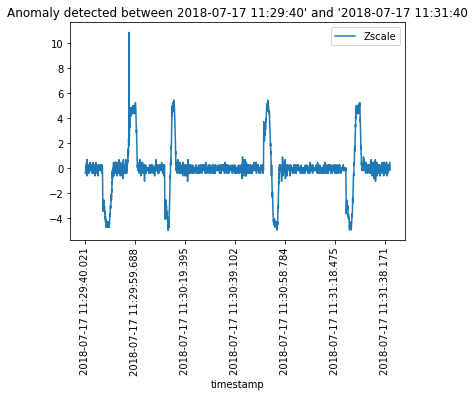

In [24]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-17 11:29:40' and '2018-07-17 11:31:40")
plt.xticks(rotation=90)

In [25]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 97.9 ms, sys: 5.37 ms, total: 103 ms
Wall time: 21 s


(array([736892.47899306, 736892.47916667, 736892.47934028, 736892.47951389,
        736892.4796875 , 736892.47986111, 736892.48003472, 736892.48020833]),
 <a list of 8 Text xticklabel objects>)

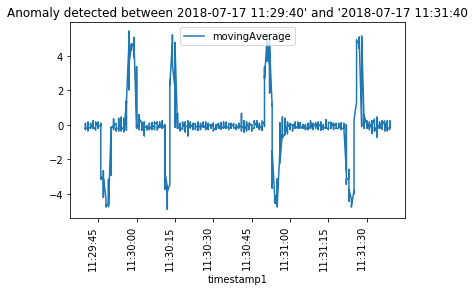

In [26]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-17 11:29:40' and '2018-07-17 11:31:40")
plt.xticks(rotation=90)

In [30]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 27 ms, sys: 3.96 ms, total: 31 ms
Wall time: 12.9 s


In [ ]:
##Anamoly 2

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 8 Text xticklabel objects>)

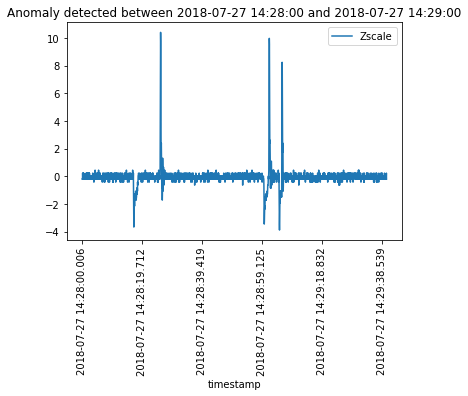

In [32]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-27 14:28:00 and 2018-07-27 14:29:00")
plt.xticks(rotation=90)

In [33]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 55.2 ms, sys: 28.7 ms, total: 83.9 ms
Wall time: 22.4 s


(array([736902.60277778, 736902.60295139, 736902.603125  , 736902.60329861,
        736902.60347222, 736902.60364583, 736902.60381944]),
 <a list of 7 Text xticklabel objects>)

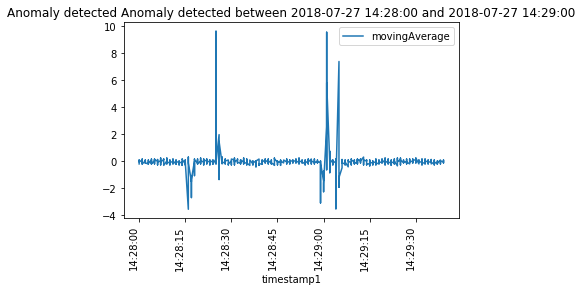

In [34]:
# This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected Anomaly detected between 2018-07-27 14:28:00 and 2018-07-27 14:29:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 3

In [38]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 22 ms, sys: 8.07 ms, total: 30.1 ms
Wall time: 10.8 s


In [39]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 59 ms, sys: 22.1 ms, total: 81.1 ms
Wall time: 16.8 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

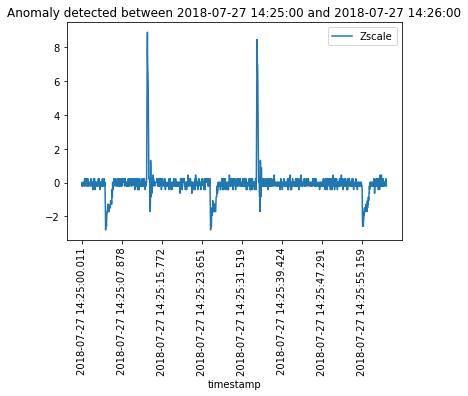

In [40]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-27 14:25:00 and 2018-07-27 14:26:00")
plt.xticks(rotation=90)

(array([736902.60069444, 736902.60081019, 736902.60092593, 736902.60104167,
        736902.60115741, 736902.60127315, 736902.60138889]),
 <a list of 7 Text xticklabel objects>)

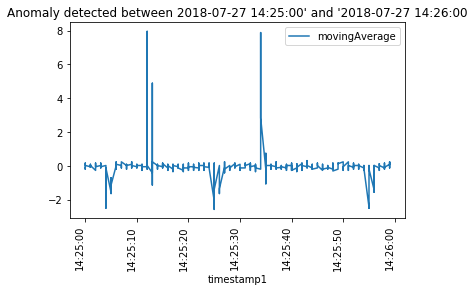

In [41]:
 #This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-27 14:25:00' and '2018-07-27 14:26:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 4

In [52]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 16.5 ms, sys: 12 ms, total: 28.6 ms
Wall time: 11.9 s


In [53]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 62.5 ms, sys: 19.6 ms, total: 82.1 ms
Wall time: 14.8 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

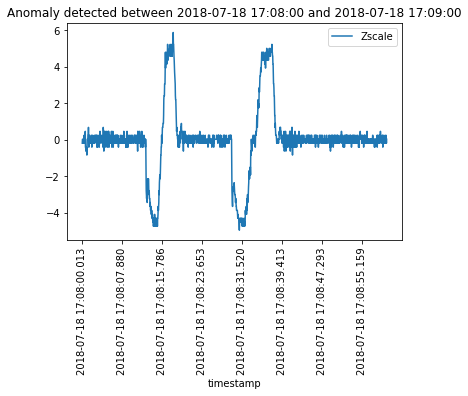

In [54]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 17:08:00 and 2018-07-18 17:09:00")
plt.xticks(rotation=90)

(array([736893.71388889, 736893.71400463, 736893.71412037, 736893.71423611,
        736893.71435185, 736893.71446759, 736893.71458333]),
 <a list of 7 Text xticklabel objects>)

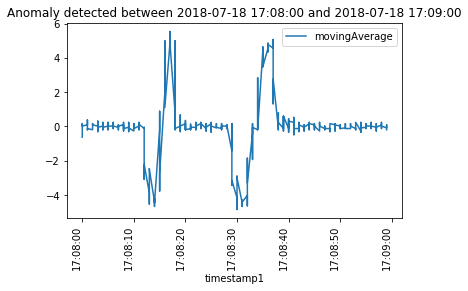

In [55]:
 #This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected between 2018-07-18 17:08:00 and 2018-07-18 17:09:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 5

In [70]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 19.1 ms, sys: 8.37 ms, total: 27.5 ms
Wall time: 9.23 s


In [71]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 64.4 ms, sys: 7.75 ms, total: 72.2 ms
Wall time: 14.4 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

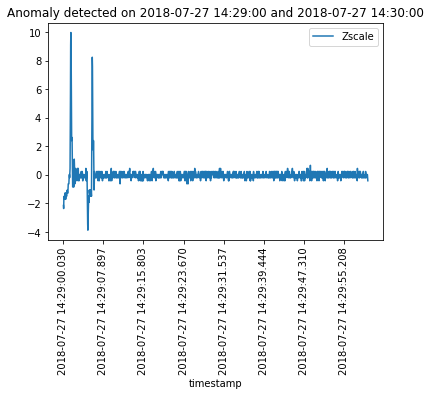

In [72]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:29:00 and 2018-07-27 14:30:00")
plt.xticks(rotation=90)

(array([736902.60347222, 736902.60358796, 736902.6037037 , 736902.60381944,
        736902.60393519, 736902.60405093, 736902.60416667]),
 <a list of 7 Text xticklabel objects>)

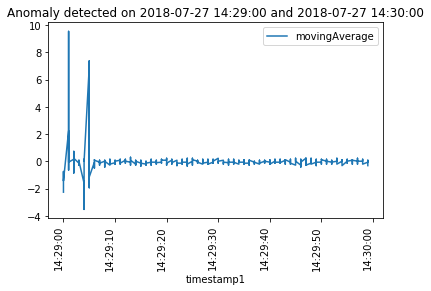

In [73]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:29:00 and 2018-07-27 14:30:00")
plt.xticks(rotation=90)

In [ ]:
##Anamoly 6

In [74]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 26.4 ms, sys: 3.58 ms, total: 30 ms
Wall time: 13.9 s


In [ ]:
%time temp_avg = movAvg.select("*").toPandas()

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

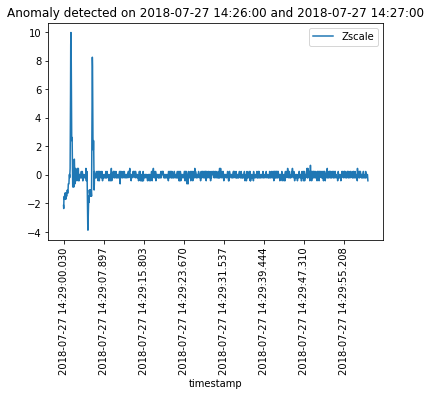

In [75]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:26:00 and 2018-07-27 14:27:00")
plt.xticks(rotation=90)

(array([736902.60347222, 736902.60358796, 736902.6037037 , 736902.60381944,
        736902.60393519, 736902.60405093, 736902.60416667]),
 <a list of 7 Text xticklabel objects>)

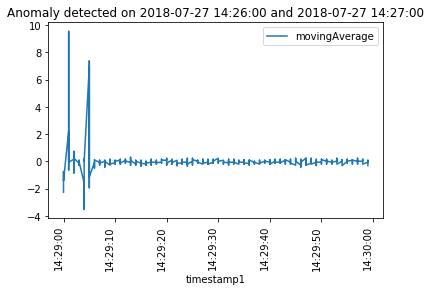

In [76]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Anomaly detected on 2018-07-27 14:26:00 and 2018-07-27 14:27:00")
plt.xticks(rotation=90)

In [ ]:
###Normal Cases

In [ ]:
##Normal Case 1

In [116]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 22.5 ms, sys: 4.47 ms, total: 27 ms
Wall time: 8.92 s


In [117]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 44 ms, sys: 16 ms, total: 60.1 ms
Wall time: 2.23 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

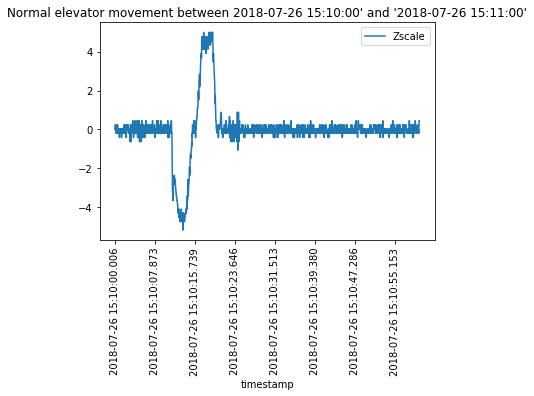

In [118]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal elevator movement between 2018-07-26 15:10:00' and '2018-07-26 15:11:00'")
plt.xticks(rotation=90)

(array([736901.63194444, 736901.63206019, 736901.63217593, 736901.63229167,
        736901.63240741, 736901.63252315, 736901.63263889]),
 <a list of 7 Text xticklabel objects>)

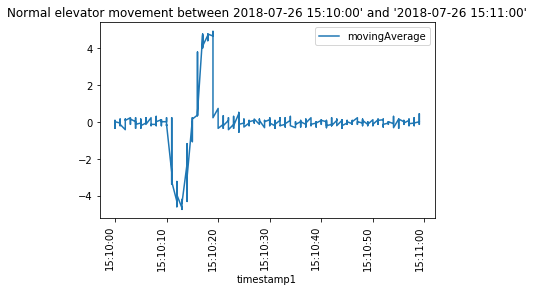

In [119]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Normal elevator movement between 2018-07-26 15:10:00' and '2018-07-26 15:11:00'")
plt.xticks(rotation=90)

In [ ]:
##Normal 2

In [97]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 15.5 ms, sys: 15.2 ms, total: 30.7 ms
Wall time: 9.45 s


In [98]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 64 ms, sys: 15.8 ms, total: 79.8 ms
Wall time: 15.7 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600.]),
 <a list of 10 Text xticklabel objects>)

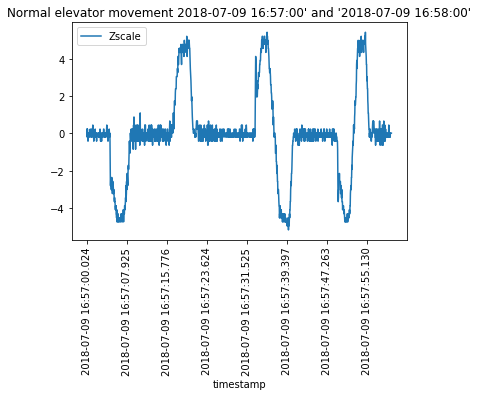

In [101]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal elevator movement 2018-07-09 16:57:00' and '2018-07-09 16:58:00'")
plt.xticks(rotation=90)

(array([736884.70625   , 736884.70636574, 736884.70648148, 736884.70659722,
        736884.70671296, 736884.7068287 , 736884.70694444]),
 <a list of 7 Text xticklabel objects>)

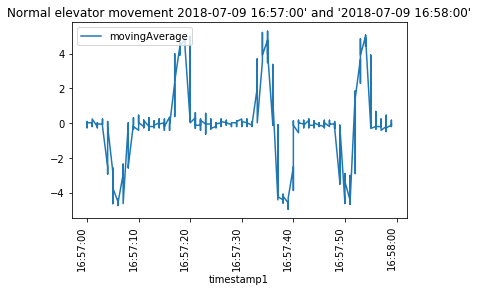

In [102]:
#This is the plot for window size 3
temp_avg.plot(x ='timestamp1', y='movingAverage', kind = 'line')
plt.title("Normal elevator movement 2018-07-09 16:57:00' and '2018-07-09 16:58:00'")
plt.xticks(rotation=90)

In [ ]:
##Normal Case 3

In [108]:
%time temp_pandas = temp_df.select("*").toPandas()

CPU times: user 23.4 ms, sys: 4.56 ms, total: 28 ms
Wall time: 9.89 s


In [109]:
%time temp_avg = movAvg.select("*").toPandas()

CPU times: user 48.9 ms, sys: 24.2 ms, total: 73.1 ms
Wall time: 15.1 s


(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200., 1400.,
        1600., 1800.]),
 <a list of 11 Text xticklabel objects>)

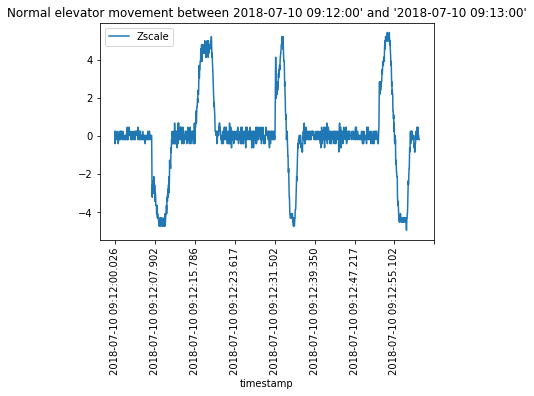

In [110]:
temp_pandas.plot(x ='timestamp', y='Zscale', kind = 'line')
plt.title("Normal elevator movement between 2018-07-10 09:12:00' and '2018-07-10 09:13:00'")
plt.xticks(rotation=90)